# Local differential privacy for privacy-preserving data analysis.


In [1]:
import math
import numpy as np
import pandas as pd
import numpy.random as npr
import itertools as it
import matplotlib.pyplot as plt
from IPython.display import display, HTML

npr.seed(2)

## Task 1: Randomised response.

Let us consider the so-called "randomised response" mechanism for collecting responses to a potentially embarrassing or private question. In this mechanism, the respondents are instructed to as follows:

1. Flip a coin.
2. If **tails**, then respond truthfully.
3. If **heads**, then flip a second coin and respond *Yes* if heads and *No* if tails.

i. Calculate the probability of the randomised response being "yes" and the probability of the randomised response being "no", conditional to true response being "yes"/"no".

ii. Verify that this mechanism satisfies local $\epsilon$-DP with $\epsilon = \ln 3$.

iii. Assuming a population of independent respondents who have the probability $\pi$ to answer yes. Design a method to estimate $\pi$ from the noisy responses. Simulate the mechanism with $n$ participants for $n = 10, 100, 1000, 10000$ with $\pi = 0.01, 0.1$. How accurately can you estimate $\pi$ in the different cases?


I.  
$Pr(yes|truth=yes) = Pr(yes,random|truth=yes) + Pr(yes,non-random|truth=yes) = $  
$Pr(yes|random)Pr(coin = random) + Pr(yes|truth=yes,coin=non-random)Pr(coin=non-random) =  $  
$0.5\cdot0.5 + 1 \cdot0.5 = 0.75$

Similarly, $Pr(no|truth=yes) = 0.25$, $Pr(no|truth=no) = 0.75$, $Pr(yes|truth=no) = 0.25$.

II.  

$\frac{Pr(yes|truth=yes)}{Pr(yes|truth=no)}= 3 \leq e^{\epsilon} \Leftrightarrow \ln(3) \leq \epsilon$

In [2]:
#i) Monte Carlo simulation
n = 10000

truth = 'yes'
random_choice = np.where(npr.uniform(size=n)>0.5, 'yes', 'no')
choice = np.where(npr.uniform(size=n)>0.5, truth, random_choice)
ctr = (choice==truth).sum()
print(f'P({truth} | truth = {truth}) = {ctr/n:.2f}, P({"no" if truth == "yes" else "yes"} | truth = {truth}) = {(n-ctr)/n:.2f}')

truth = 'no'
random_choice = np.where(npr.uniform(size=n)>0.5, 'yes', 'no')
choice = np.where(npr.uniform(size=n)>0.5, truth, random_choice)
ctr = (choice==truth).sum()
print(f'P({truth} | truth = {truth}) = {ctr/n:.2f}, P({"no" if truth == "yes" else "yes"} | truth = {truth}) = {(n-ctr)/n:.2f}')

P(yes | truth = yes) = 0.75, P(no | truth = yes) = 0.25
P(no | truth = no) = 0.75, P(yes | truth = no) = 0.25


In [3]:
truth = 'yes'
random_choice = np.where(npr.uniform(size=n)>0.5, 'yes', 'no')
choice = np.where(npr.uniform(size=n)>0.5, truth, random_choice)
(choice==truth).sum()/n

0.7511

In [4]:
#ii)

$$ \frac{\mathcal{P}(\text{yes}|\text{truth=yes})}{\mathcal{P}(\text{yes}|\text{truth=no})} = \frac{0.5\cdot (1_{truth} + 0.5\cdot(0+1_{truth}))}{0.5\cdot(0_{truth}+0.5\cdot(1+0_{truth}))} = e^{\epsilon} = 3 \Leftrightarrow \epsilon = \ln(3) $$

In [5]:
#iii)
n_, pi_ = [10, 100, 1000, 10000], [0.01, 0.1]
for pi, n in it.product(pi_, n_):
    truth = np.where(npr.uniform(size=n)>pi, 'yes', 'no')
    random = np.where(npr.uniform(size=n)>0.5, 'yes', 'no')
    choice = np.where(npr.uniform(size=n)>0.5, truth, random)
    i = (choice=='yes').sum()
    print(f'n: {n}, pi: {pi}, estimate: {max(round((i/n-.25)*2,4),0):.2f}')

n: 10, pi: 0.01, estimate: 1.30
n: 100, pi: 0.01, estimate: 0.90
n: 1000, pi: 0.01, estimate: 0.99
n: 10000, pi: 0.01, estimate: 0.98
n: 10, pi: 0.1, estimate: 0.90
n: 100, pi: 0.1, estimate: 1.00
n: 1000, pi: 0.1, estimate: 0.88
n: 10000, pi: 0.1, estimate: 0.91


For the $\pi = 0.1$ even low numbers of samples are sufficient to be rather close to the true value; whereas even 10000 samples do not suffice to be within a $+- 10\%$ bound.

## Task 2: Generalising randomised response

Consider a generalised randomised response mechanism, where each person flips $k$ coins in step 1 and responds truthfully if either  
i. all of them display tails  
ii. any one of them displays tails.

Verify that both of these produce $\epsilon$-DP mechanisms for each $k$. Evaluate and plot $\epsilon$ as a function of $k$ for each case and $k = 1, \dots, 10$.

Verification.  
Case 1:  
$Pr(yes|truth=yes) = 0.5^{k} + (1-0.5^{k})\cdot 0.5 = 0.5(0.5^{k} + 1)$, using symmetry properties:
$Pr(yes|truth=no) = 1 - Pr(yes|truth=yes)$  
$\frac{Pr(yes|truth=yes)}{Pr(yes|truth=no)} = 
\frac{0.5(0.5^{k} + 1)}{1-(0.5(0.5^{k} + 1))} = 
\frac{0.5(0.5^{k} + 1)}{1-(0.5^{k}0.5 - 0.5)} = 
\frac{0.5(0.5^{k} + 1)}{0.5(1-0.5^{k})} = 
\frac{0.5^{k} + 1}{1-0.5^{k}} 
\leq 
e^{\epsilon}$  
Obviously, this produces an $\epsilon$-DP mechanisms for each $k$, where privacy increases ($\epsilon$ decreases) with increasing $k$.

Case 2: Inversion of case 1 given symmetric probabilities of tails and heads.  
$Pr(yes|truth=yes) = (1-0.5^{k}) + 0.5^{k}\cdot 0.5 = 1+0.5^{k}(0.5-1) =1-0.5\cdot 0.5^{k}$
, using symmetry properties:
$Pr(yes|truth=no) = 1 - Pr(yes|truth=yes)$  
$\frac{Pr(yes|truth=yes)}{Pr(yes|truth=no)} = 
\frac{1-0.5\cdot 0.5^{k}}{1-(1-0.5\cdot 0.5^{k})} = 
\frac{1-0.5\cdot 0.5^{k}}{0.5\cdot 0.5^{k}} =
\frac{2-0.5^{k}}{0.5^{k}} \leq e^{\epsilon}$  
Obviously, this produces an $\epsilon$-DP mechanisms for each $k$, where privacy decreases ($\epsilon$ increases) with increasing $k$.

In [6]:
def p_random(k, mode='i'):
    if mode=='i':
        return 1-.5**k
    if mode=='ii':
        return 1-(1-.5**k) #ofc could be just .5**k

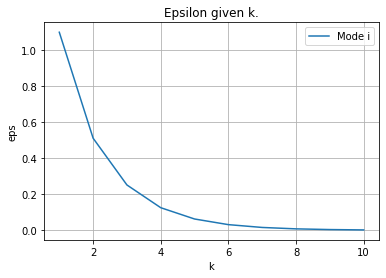

In [7]:
vec_random = np.vectorize(p_random)
x = np.arange(1,11)
y = (1-vec_random(x)) + vec_random(x)*0.5
eps = y/(1-y)
eps = np.log(eps)


fig, ax = plt.subplots()
ax.plot(x,eps, label = 'Mode i')
ax.set(xlabel='k', ylabel='eps',
       title='Epsilon given k.')
ax.grid()
ax.legend()
plt.show()

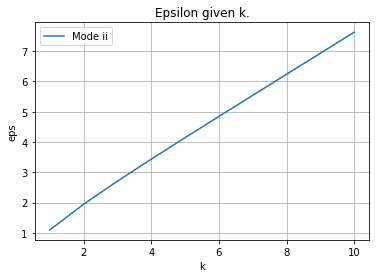

In [8]:
vec_random = np.vectorize(p_random)
x = np.arange(1,11)
y = (1-vec_random(x,mode='ii')) + vec_random(x,mode='ii')*0.5
eps = y/(1-y)
eps = np.log(eps)

fig, ax = plt.subplots()
ax.plot(x,eps, label = 'Mode ii')
ax.set(xlabel='k', ylabel='eps',
       title='Epsilon given k.')
ax.grid()
ax.legend()
plt.show()

## Task 3: How much money do you have on your bank account?

To answer a question about a scalar value, we need a different mechanism. Here we use the Laplace mechanism, which works as follows:

* Evaluate the *sensitivity* of the function $f$ of interest:
$$ \Delta f = \max\limits_{\mathcal{D} \sim \mathcal{D}'} | f(\mathcal{D}) - f(\mathcal{D}') |, $$
where $\mathcal{D} \sim \mathcal{D}'$ denotes pairs of data sets that differ by a single sample.
* Compute $\mathcal{M}(\mathcal{D}) = f(\mathcal{D}) + \frac{\Delta f}{\epsilon} \eta$
where $\eta \sim \operatorname{Laplace}(0, 1)$

In this exercise we apply the Laplace mechanism in locally differentially private mode, i.e. each individual is assumed to form a different single-observation data set that is protected using this mechanism.

In order to estimate the mean of the distribution of data held by the users, we can use the following moment identities with $x$ denoting the user data and $z$ denoting the Laplace noise added for DP:
$$ \mathrm{E}[x + z] = \mathrm{E}[x] + \mathrm{E}[z], $$
$$ \mathrm{Var}[x + z] = \mathrm{Var}[x] + \mathrm{Var}[z]. $$

i) What is the probability $Pr(\mathcal{M}(\mathcal{D})=s)$ for some outcome $s$? Also, find the ratio $\frac{Pr(\mathcal{M}(\mathcal{D})=s)}{Pr(\mathcal{M}(\mathcal{D}')=s)}$.

ii) (Optional) Verify that this mechanism satisfies $\epsilon$-DP.

iii) Assuming a population of independent respondents whose bank account balances follow the exponential distribution $\mathrm{Exp}(\lambda)$ with $\lambda = 1/5000$. Simulate the mechanism for $n$ participants with $n = 10, 100, 1000, 10000$. How accurately can you estimate the mean and the standard deviation of the bank account balance distribution?
Repeat each simulation 100 times to get an idea of the accuracy.

Hint: you will need to set an upper bound on the allowed balances to get a bounded sensitivity. Larger values can be handled e.g. by setting them to the maximum. In order to guarantee DP, this bound should be selected independently of the actual data at hand. (Mechanisms that do not require such an a priori bound exist, but are more complicated. If you are interested, see e.g. https://dl.acm.org/citation.cfm?id=1250803.)


In [9]:
np.random.seed(6)

simulations = 100
participants = [10, 100, 1000, 10000]
inv_scale = 1/5000
eps = 10
upper_bound = 100000
lower_bound = 0
mu = sensitivity = upper_bound-lower_bound
report = pd.DataFrame()

for n in participants:
    D = npr.exponential(scale = 1/inv_scale, size=(n,simulations))
    np.clip(D,lower_bound,upper_bound)
    avg_, std_ = D.mean(axis=0), D.std(axis=0)

    eta = npr.laplace(loc=0.0, scale=1.0, size=(n,simulations))
    D = npr.exponential(scale = 1/inv_scale, size=(n,simulations))
    D += (mu/eps)*eta
    np.clip(D,lower_bound,upper_bound)
    avg, std = D.mean(axis=0), D.std(axis=0)
    report = report.append(pd.Series([n,avg_.mean(),std_.mean(),avg.mean(),std.mean(),std.mean()-mu/eps]),ignore_index=True)
    
report.columns = ['n','True Mean', 'True Std.', 'Noisy Mean', 'Noisy Std.', 'Estimated Std.']
display(HTML(report.round(2).to_html()))

,n,True Mean,True Std.,Noisy Mean,Noisy Std.,Estimated Std.
0,10.0,5052.18,4303.96,5416.01,13773.56,3773.56
1,100.0,4996.74,4898.50,4966.94,14579.81,4579.81
2,1000.0,4983.62,4988.29,5032.42,14932.69,4932.69
3,10000.0,4997.40,4991.35,4998.94,15011.66,5011.66


The first row reports the difference between the mean of the actual data and the mean of 100 simulated added-noise data set means as well as its deviations.  
The actual mean and the mean of 100 means is reported below.  
The third row reports the two drifferent standard deviations in the same manner.  
The fourth row shows the estimated standard deviation of the noisy dataset, where sensitivity and $\epsilon$ information
is used to gauge the noise variance. The mean of 100 data sets is reported. Furthermore the variation of the estimated standard deviation is reported as well.

The mean approaches the true mean rather quick over multiple simulations, the bias standard deviation shows that only with n=10000, the value becomes somewhat stable and small. (Standard deviation reflects less than 10\% of the actual value) As the noise just adds a fixed variance, the estimate is pretty accurate over multiple simulations right away, but for stability reasons needs a bit to approach acceptable levels (n=1000). Obviously, if we would not have any information regarding the sensitivity/epsilon used, we could not converge towards the true variation in the data (obviously?).


i)  
$$Pr(\mathcal{M}(\mathcal{D})=s) = 
Pr(f(\mathcal{D}) + \frac{\Delta f}{\epsilon} \eta=s) = 
Pr(\eta = \frac{\epsilon}{\Delta f}(s - f(\mathcal{D})), \eta \sim \operatorname{Laplace}(0, 1)$$  
$$Pr\left(\eta = \frac{\epsilon}{\Delta f}(s - f(\mathcal{D}))\right) = 
{\displaystyle {\frac {1}{2}}\exp \left(-{\frac {|\epsilon}{\Delta f}(s - f(\mathcal{D}) |}\right)}$$
$$\frac{Pr(\eta = \frac{\epsilon}{\Delta f}(s - f(\mathcal{D}))}{Pr(\eta = \frac{\epsilon}{\Delta f}(s - f(\mathcal{D'}))} =   
\frac{{\displaystyle \exp \left(-|\frac{\epsilon}{\Delta f}(s - f(\mathcal{D})) |\right)}}
{{\displaystyle \exp \left(-|\frac{\epsilon}{\Delta f}(s - f(\mathcal{D'})) |\right)}} $$
$$= {\displaystyle \exp \left(-|\frac{\epsilon}{\Delta f}(s - f(\mathcal{D})) | + |\frac{\epsilon}{\Delta f}(s - f(\mathcal{D'})) |\right)} $$
$$= {\displaystyle \exp \left(\frac{\epsilon}{\Delta f}\left(|s - f(\mathcal{D'}) | - |s - f(\mathcal{D}) |\right)\right)} $$
$$ = {\displaystyle \exp \left(\frac{\epsilon}{\Delta f}\left(f(\mathcal{D}) - f(\mathcal{D'}) \right)\right)}$$

ii)

$${\displaystyle \exp \left(\frac{\epsilon}{\Delta f}\left(f(\mathcal{D}) - f(\mathcal{D'}) \right)\right)} \leq \exp(\epsilon) $$  
$$ \Leftrightarrow {\displaystyle           \frac{\epsilon}{\Delta f}\left(f(\mathcal{D}) - f(\mathcal{D'}) \right)} \leq \epsilon$$  
$$ \Leftrightarrow {\displaystyle           \frac{\left(f(\mathcal{D}) - f(\mathcal{D'}) \right)}{\Delta f}} \leq 1$$  
$$ \Leftrightarrow {\displaystyle           \frac{\left(f(\mathcal{D}) - f(\mathcal{D'}) \right)}{\max\limits_{\mathcal{D} \sim \mathcal{D}'} | f(\mathcal{D}) - f(\mathcal{D}') |}} \leq 1$$  

By definition the following is true:
$$ {\displaystyle f(\mathcal{D}) - f(\mathcal{D'}) \leq \max\limits_{\mathcal{D} \sim \mathcal{D}'} | f(\mathcal{D}) - f(\mathcal{D}') |}$$
<div align='right'>$\square$</div>

## Task 4: Does your age affect your account balance?

We can apply the Laplace mechanism to fit a linear regression model to model the bank account balance as a function of age. We know that the respondents are of age 20-70 years and their account balances are at most 150000.

Linear regression fit to scalar $x_i, y_i$ involves fitting the model
$$ y_i = \alpha + \beta x_i + \epsilon_i, $$
where $\beta$ is the regression coefficient and $\alpha$ is the intercept. Assuming regression errors $\epsilon_i$ are normally distributed, the maximum likelihood estimates of the parameters are
$$ \hat{\beta}= \frac{\sum_{i = 1}^n (x_i - \bar{x})(y_i - \bar{y}) }{ \sum_{i = 1}^n (x_i - \bar{x})^2} \\
   \hat{\alpha} = \bar{y} - \hat{\beta} \bar{x},$$
where $\bar{x} = \frac{1}{n} \sum_{i = 1}^n x_i$ and $\bar{y} = \frac{1}{n} \sum_{i = 1}^n y_i$.

i. Use the data in "balances.csv" loaded below, and release $x$ (the age) and $y$ (the bank account balance) using Laplace mechanism with total privacy loss $\epsilon=1$ and fit the regression model to the noisy data. Repeat the process 100 times and evaluate how the model compares with one learned from clean data. Because you are releasing the composition of two queries, you will need to use $\epsilon/2$ as the $\epsilon$ for each query to reach total privacy loss of $\epsilon$.

ii. Design a two-step protocol that first estimates the means $\bar{x}$ and $\bar{y}$, and then uses these to release the terms $(x_i - \bar{x}) (y_i - \bar{y})$, $(x_i - \bar{x})^2$ using the Laplace mechanism. Fit the regression model using the noisy information. Compare with the above. In order to make the results comparable, the total privacy loss should be $\epsilon=1$. Because you are releasing the composition of four queries, you will need to use $\epsilon/4$ as the $\epsilon$ for each query to reach total privacy loss of $\epsilon$.

iii. Repeat the above cases with total privacy loss $\epsilon = 10$ and compare the results.

Hint: you can use the known range of values of $x$ and $y$ to bound the sensitivites. For the two-step protocol, you can also use the published private means $\bar{x}$ and $\bar{y}$ to evaluate the sensitivity for the second step, as long as you do not use any other features of the specific data set.

Comment: a better solution would take into account the knowledge of the noise added. Developing algorithms like this is in many cases still an open research problem. Furthermore, the privacy budget can be split between different queries arbitrarily, not necessarily evenly like here.

In [10]:
data = pd.read_csv('../data/balances.csv', header=0, index_col=0)

x = data.values[:,0]
y = data.values[:,1]
N = len(data)
eps = 1
#dF_x = x.max() - x.min()
#dF_y = y.max() - y.min()
dF_x = 50
dF_y = 100000

i. Use the data in "balances.csv" loaded below, and release $x$ (the age) and $y$ (the bank account balance) using Laplace mechanism with total privacy loss $\epsilon=1$ and fit the regression model to the noisy data. Repeat the process 100 times and evaluate how the model compares with one learned from clean data. Because you are releasing the composition of two queries, you will need to use $\epsilon/2$ as the $\epsilon$ for each query to reach total privacy loss of $\epsilon$.

In [11]:
b, a = [], []
np.random.seed(1)
for _ in range(100):
    x_prv = x + npr.laplace(0,1,size=N)*(dF_x/(eps/2))
    y_prv = y + npr.laplace(0,1,size=N)*(dF_y/(eps/2))
    #y_prv = np.clip(y_prv, -150000, 150000)
    b_hat = sum((x_prv-x_prv.mean())*(y_prv-y_prv.mean()))/sum((x_prv-x_prv.mean())**2)
    a_hat = y_prv.mean() - b_hat*x_prv.mean()
    b.append(b_hat)
    a.append(a_hat)

In [12]:
b_hat = np.mean(b)
a_hat = np.mean(a)
b_hat, a_hat 
print(f'Estimated parameters on privatized data (100 runs):')
print(f'beta: {round(b_hat,2)} with sd: {np.std(b)}')
print(f'alpha: {round(a_hat,2)} with sd: {np.std(a)}')

Estimated parameters on privatized data (100 runs):
beta: 15.14 with sd: 62.21139294190902
alpha: 49514.46 with sd: 10198.189293584526


In [13]:
b_hat = sum((x-x.mean())*(y-y.mean()))/sum((x-x.mean())**2)
a_hat = y.mean() - b_hat*x.mean()
print(f'Estimated parameters on disclosed data.')
print(f'beta: {round(b_hat,2)}')
print(f'alpha: {round(a_hat,2)}')

Estimated parameters on disclosed data.
beta: 1146.96
alpha: -1776.36


ii. Design a two-step protocol that first estimates the means $\bar{x}$ and $\bar{y}$, and then uses these to release the terms $(x_i - \bar{x}) (y_i - \bar{y})$, $(x_i - \bar{x})^2$ using the Laplace mechanism. Fit the regression model using the noisy information. Compare with the above. In order to make the results comparable, the total privacy loss should be $\epsilon=1$. Because you are releasing the composition of four queries, you will need to use $\epsilon/4$ as the $\epsilon$ for each query to reach total privacy loss of $\epsilon$.

In [14]:
x_ = x.mean()
y_ = y.mean()
data = data.assign(cvar=lambda x: (x.Age-x_)*(x.Balance-y_), 
                   xvar=lambda x: (x.Age-x_)**2)
cvar = data.values[:,2]
xvar = data.values[:,3]
eps = 1
dF_cvar = cvar.max() - cvar.min()
dF_xvar = xvar.max() - xvar.min()
#dF_x = x.max() - x.min()
#dF_y = y.max() - y.min()
dF_x = 50
dF_y = 100000

In [15]:
b, a = [], []
np.random.seed(111)
for _ in range(100):
    cvar_prv = cvar + npr.laplace(0,1,size=N)*(dF_cvar/(eps/4))
    xvar_prv = xvar + npr.laplace(0,1,size=N)*(dF_xvar/(eps/4))
    x_prv = x + npr.laplace(0,1,size=N)*(dF_x/(eps/4))
    y_prv = y + npr.laplace(0,1,size=N)*(dF_y/(eps/4))
    y_prv = np.clip(y_prv, -150000, 150000)
    b_hat = sum(cvar_prv)/sum(xvar_prv)
    a_hat = y_prv.mean() - b_hat*x_prv.mean()
    b.append(b_hat)
    a.append(a_hat)



In [16]:
b_hat = np.mean(b)
a_hat = np.mean(a)
print(f'beta: {b_hat} with sd: {np.std(b)}')
print(f'alpha: {a_hat} with sd: {np.std(a)}')
print(f'Empirical estimates')
print(f'beta: 1146.96')
print(f'alpha: -1776.36')

beta: 825.016762953705 with sd: 6763.371942541809
alpha: -12245.576410486377 with sd: 356387.0963511269
Empirical estimates
beta: 1146.96
alpha: -1776.36


Both estimations are far off compared to the original data, yet when adding noise to the Age and Balance directly and doing the estimation on those like in case 1, the estimations on the beta are far too concentrated and most is captured by the alpha.
With the 2-step approach, adding the noise to the (co-)variance, both estimates are fairly unconcentrated which at least does not give a false sense of accuracy.

iii. Repeat the above cases with total privacy loss $\epsilon = 10$ and compare the results.

In [17]:
data = pd.read_csv('../data/balances.csv', header=0, index_col=0)

x = data.values[:,0]
y = data.values[:,1]
N = len(data)
eps = 10
#df_x = x.max() - x.min()
#df_y = y.max() - y.min()
dF_x = 25
dF_y = 100000
b, a = [], []
np.random.seed(42)
for _ in range(100):
    x_prv = x + npr.laplace(0,1,size=N)*(dF_x/(eps/2))
    y_prv = y + npr.laplace(0,1,size=N)*(dF_y/(eps/2))
    #y_prv = np.clip(y_prv, -150000, 150000)
    b_hat = sum((x_prv-x_prv.mean())*(y_prv-y_prv.mean()))/sum((x_prv-x_prv.mean())**2)
    a_hat = y_prv.mean() - b_hat*x_prv.mean()
    b.append(b_hat)
    a.append(a_hat)
b_hat = np.mean(b)
a_hat = np.mean(a)
b_hat, a_hat 
print(f'private beta: {round(b_hat,2)} with sd: {np.std(b)}')
print(f'private alpha: {round(a_hat,2)} with sd: {np.std(a)}')
b_hat = sum((x-x.mean())*(y-y.mean()))/sum((x-x.mean())**2)
a_hat = y.mean() - b_hat*x.mean()
print(f'`true` beta: {round(b_hat,2)}')
print(f'`true` alpha: {round(a_hat,2)}')

private beta: 911.99 with sd: 59.88864771668498
private alpha: 8804.88 with sd: 2777.5948511889064
`true` beta: 1146.96
`true` alpha: -1776.36


In [18]:
eps = 10
df_x = 25
df_y = 100000
dF_cvar = dF_x * df_y
dF_xvar = dF_x**2

b, a = [], []
np.random.seed(1)
for _ in range(100):
    x_prv = x + npr.laplace(0,1,size=N)*(dF_x/(eps/4))
    y_prv = y + npr.laplace(0,1,size=N)*(dF_y/(eps/4))
    y_prv = np.clip(y_prv, 0, 100000)
    x_ = x_prv.mean()
    y_ = y_prv.mean()
    cvar = (x-x_)*(y-y_)
    xvar = (x-x_)**2
    cvar_prv = cvar + npr.laplace(0,1,size=N)*(dF_cvar/(eps/4))
    xvar_prv = xvar + npr.laplace(0,1,size=N)*(dF_xvar/(eps/4))
    b_hat = sum(cvar_prv)/sum(xvar_prv)
    a_hat = y_prv.mean() - b_hat*x_prv.mean()
    b.append(b_hat)
    a.append(a_hat)

b_hat = np.mean(b)
a_hat = np.mean(a)
print(f'beta: {b_hat} with sd: {np.std(b)}')
print(f'alpha: {a_hat} with sd: {np.std(a)}')
print(f'`true` beta: 1146.96')
print(f'`true` alpha: -1776.36')

beta: 1153.3546206290018 with sd: 260.4937937831631
alpha: -2122.4210251790846 with sd: 11923.126886969232
`true` beta: 1146.96
`true` alpha: -1776.36


With more privacy budget, we can observe two things:
a) When adding direct noise prior to the estimation (case 1), most of the noise still ends up in the intercept $\alpha$ and artifically surpresses a directional effect through $\beta$. This only slowly dissipates, ie with an almost not privatized data set such as $\epsilon = 100$, the estimates approach the true values.

b) Adding the noise to the (co-)variances (case 2), adding privacy budget translates directly into proportionally better estimates. It does not seem to prefer either intercept or slope right off the bat and seems to be the prefered method, when using regression on privatized data.
The primary benefit seems to be less precision.